In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.path import Path

from joblib import Parallel, delayed

from collections import deque

In [2]:
sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

In [3]:
from enum import Enum

class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'

In [4]:
from skimage.measure import find_contours

from matplotlib.path import Path

sys.path.append('/home/yuncong/Brain/preprocess/morphsnakes')
import morphsnakes

from shapely.geometry import Polygon

In [5]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'
scoremaps_rootdir = '/home/yuncong/csd395/CSHL_scoremaps_lossless/'
autoAnnotations_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_autoAnnotations_snake'
autoAnnotationViz_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_autoAnnotationsViz_snake'

In [6]:
stack = 'MD593'

autoAnnotationViz_dir = autoAnnotationViz_rootdir + '/' + stack
if not os.path.exists(autoAnnotationViz_dir):
    os.makedirs(autoAnnotationViz_dir)

first_bs_sec, last_bs_sec = section_range_lookup[stack]
first_detect_sec, last_detect_sec = detect_bbox_range_lookup[stack]

dm = DataManager(stack=stack)

# labels_to_detect = ['5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL']
# labels_to_detect = ['7n']

labels_to_detect = set(['5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 
                     '6N', 'Amb', 'R', 'Tz', 'Sol', 'RtTg', 'LRt', 'LC', 'AP', 'sp5'])

In [ ]:
section_contains_label = {}
# for sec in range(first_bs_sec, last_bs_sec+1):
#     dm = DataManager(stack=stack, section=sec)
#     try:
#         user, ts, _, res = dm.load_proposal_review_result('yuncong', 'latest', 'consolidated')
#         section_contains_label[sec] = set([lm['label'] for lm in res])
#     except:
#         pass

In [7]:
def find_contour_points(labelmap):
    '''
    return is (x,y)
    '''

    regions = regionprops(labelmap)

    contour_points = {}

    for r in regions:

        (min_row, min_col, max_row, max_col) = r.bbox

        padded = np.pad(r.filled_image, ((5,5),(5,5)), mode='constant', constant_values=0)

        contours = find_contours(padded, .5, fully_connected='high')
        contours = [cnt.astype(np.int) for cnt in contours if len(cnt) > 10]
        if len(contours) > 0:
#             if len(contours) > 1:
#                 sys.stderr.write('%d: region has more than one part\n' % r.label)
                
            contours = sorted(contours, key=lambda c: len(c), reverse=True)
            contours_list = [c-(5,5) for c in contours]
            contour_points[r.label] = sorted([c[np.arange(0, c.shape[0], 10)][:, ::-1] + (min_col, min_row) 
                                for c in contours_list], key=lambda c: len(c), reverse=True)
            
        elif len(contours) == 0:
#             sys.stderr.write('no contour is found\n')
            continue

    #         viz = np.zeros_like(r.filled_image)
    #         viz[pts_sampled[:,0], pts_sampled[:,1]] = 1
    #         plt.imshow(viz, cmap=plt.cm.gray);
    #         plt.show();
        
    return contour_points

In [8]:
test_volume_atlas_projected = bp.unpack_ndarray_file(volume_dir + '/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})
print test_volume_atlas_projected.shape

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
    np.loadtxt(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_limits.txt' % {'stack': stack}), dtype=np.int)
    
# labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL']
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 
                     '6N', 'Amb', 'R', 'Tz', 'Sol', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

label_dict = dict([(l,i) for i, l in enumerate(labels)])

(476, 732, 456)


In [9]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled
    
# build annotation volume
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end


map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, 
                   int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
        map_z_to_section[z] = s

69 350


In [10]:
# plt.imshow(test_volume_atlas_projected[..., 40])

In [472]:
from skimage.morphology import binary_closing, disk, binary_dilation, binary_erosion, remove_small_holes
import skimage.morphology

In [89]:
from skimage.measure import grid_points_in_poly, subdivide_polygon, approximate_polygon

In [697]:
def show_contours(cnts, bg, title):
    viz = bg.copy()
    for cnt in cnts:
        for c in cnt:
            cv2.circle(viz, tuple(c.astype(np.int)), 1, (0,255,0), -1)
        cv2.polylines(viz, [cnt.astype(np.int)], True, (0,255,0), 2)
        
    plt.figure(figsize=(10,10));
    plt.imshow(viz);
    plt.title(title);
    plt.show();

In [695]:
def show_levelset(levelset, bg, title):
    viz = bg.copy()
    cnts = find_contours(levelset, .5)
    for cnt in cnts:
        for c in cnt[:,::-1]:
            cv2.circle(viz, tuple(c.astype(np.int)), 1, (0,255,0), -1)
    plt.figure(figsize=(10,10));
    plt.imshow(viz);
    plt.title(title);
    plt.show();

In [196]:
# from scipy.spatial import Delaunay, ConvexHull
# import networkx as nx

# def concave(points,alpha_x=150,alpha_y=250):
#     points = [(i[0],i[1]) if type(i) <> tuple else i for i in points]
#     de = Delaunay(points)
#     dec = []
#     a = alpha_x
#     b = alpha_y
#     for i in de.simplices:
#         tmp = []
#         j = [points[c] for c in i]
#         if abs(j[0][1] - j[1][1]) > a or abs(j[1][1]-j[2][1]) > a or abs(j[0][1]-j[2][1]) > a or abs(j[0][0]-j[1][0]) > b or abs(j[1][0]-j[2][0]) > b or abs(j[0][0]-j[2][0]) > b:
#             continue
#         for c in i:
#             tmp.append(points[c])
#         dec.append(tmp)
#     G = nx.Graph()
#     for i in dec:
#             G.add_edge(i[0], i[1])
#             G.add_edge(i[0], i[2])
#             G.add_edge(i[1], i[2])
#     ret = []
#     for graph in nx.connected_component_subgraphs(G):
#         ch = ConvexHull(graph.nodes())
#         tmp = []
#         for i in ch.simplices:
#             tmp.append(graph.nodes()[i[0]])
#             tmp.append(graph.nodes()[i[1]])
#         ret.append(tmp)
#     return ret  
# #     return [graph.nodes() for graph in nx.connected_component_subgraphs(G)]

In [730]:
from itertools import chain

In [767]:
# http://deparkes.co.uk/2015/02/01/find-concave-hull-python/
# http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import MultiLineString
from scipy.spatial import Delaunay
import numpy as np

def alpha_shape(coords, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    
    tri = Delaunay(coords)
    
    pa = coords[tri.vertices[:,0]]
    pb = coords[tri.vertices[:,1]]
    pc = coords[tri.vertices[:,2]]
    
    a = np.sqrt(np.sum((pa - pb)**2, axis=1))
    b = np.sqrt(np.sum((pb - pc)**2, axis=1))
    c = np.sqrt(np.sum((pc - pa)**2, axis=1))
    s = (a + b + c)/2.
    area = np.sqrt(s*(s-a)*(s-b)*(s-c))
    circum_r = a*b*c/(4.0*area)
    
    edges = tri.vertices[circum_r < 1.0/alpha]

# slightly slower than below
#     edge_points = list(chain(*[[coords[ [ia, ib] ], coords[ [ib, ic] ], coords[ [ic, ia] ]]
#                    for ia, ib, ic in edges]))
    
    edge_points = []
    for ia, ib, ic in edges:
        edge_points.append(coords[ [ia, ib] ])
        edge_points.append(coords[ [ib, ic] ])
        edge_points.append(coords[ [ic, ia] ])

    m = MultiLineString(edge_points)
    triangles = list(polygonize(m))
    r = cascaded_union(triangles)
    
    return r

0.021448135376


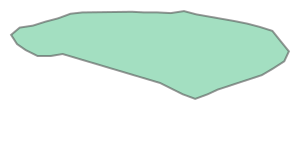

In [766]:
import time
t = time.time()
p = alpha_shape(new_cnt_subsampled, alpha=.01)
print time.time() - t

p

In [226]:
def less(center):
    def less_helper(a, b):
        if (a[0] - center[0] >= 0 and b[0] - center[0] < 0):
            return 1;
        if (a[0] - center[0] < 0 and b[0] - center[0] >= 0):
            return -1;
        if (a[0] - center[0] == 0 and b[0] - center[0] == 0):
            if (a[1] - center[1] >= 0 or b[1] - center[1] >= 0):
                return 2*int(a[1] > b[1]) - 1;
            return 2*int(b[1] > a[1]) - 1

        # compute the cross product of vectors (center -> a) x (center -> b)
        det = (a[0] - center[0]) * (b[1] - center[1]) - (b[0] - center[0]) * (a[1] - center[1])
        if (det < 0):
            return 1;
        if (det > 0):
            return -1;

        # points a and b are on the same line from the center
        # check which point is closer to the center
        d1 = (a[0] - center[0]) * (a[0] - center[0]) + (a[1] - center[1]) * (a[1] - center[1])
        d2 = (b[0] - center[0]) * (b[0] - center[0]) + (b[1] - center[1]) * (b[1] - center[1])
        return 2*int(d1 > d2) - 1
    
    return less_helper

def sort_vertices_counterclockwise(cnt):
    # http://stackoverflow.com/a/6989383
    center = cnt.mean(axis=0)
    return sorted(cnt, cmp=less(center))

In [313]:
from itertools import izip

In [461]:
# plt.imshow(plt.cm.hot([[0, .5, .5], [.5, 0, 0.5]]))

In [802]:
def contour_to_concave_hull(cnt, alpha=.1):
    
    xmin, ymin = cnt.min(axis=0)
    xmax, ymax = cnt.max(axis=0)
    h, w = (ymax-ymin+1, xmax-xmin+1)
    inside_ys, inside_xs =np.where(grid_points_in_poly((h, w), cnt[:, ::-1]-(ymin,xmin))) 
    n = inside_ys.size
    random_indices = np.random.choice(range(n), min(1000, n), replace=False)
    inside_points = np.c_[inside_xs[random_indices], inside_ys[random_indices]]
    
    while True:
        concave_hull = alpha_shape(inside_points, alpha=alpha)
    
        if concave_hull.geometryType() == 'MultiPolygon':
            alpha -= .1
        else:
            break
    
    if not hasattr(concave_hull, 'exterior'):
        sys.stderr.write('No concave hull produced.\n')
        return None

    point_interval = 20
    new_cnt_subsampled = np.array([concave_hull.exterior.interpolate(r, normalized=True).coords[:][0] 
                         for r in np.arange(0, 1, point_interval/concave_hull.exterior.length)], 
               dtype=np.int)
    
    return new_cnt_subsampled + (xmin, ymin)

(1150.0, 1400.0, 1160.0, 1250.0)

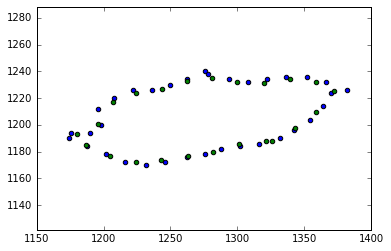

In [666]:
init_cnt = init_cnts[l]
init_cnt = contour_to_concave_hull(init_cnt, alpha=.1)

plt.scatter(init_cnts[l][:,0], init_cnts[l][:,1])
plt.scatter(init_cnt[:,0], init_cnt[:,1], c='g')
plt.axis('equal')



157
set(['7n', 'sp5', 'LVe', '7N', '5N', 'LRt', 'SuVe', 'Pn'])
LRt
initial shift [30 10] 0.670123


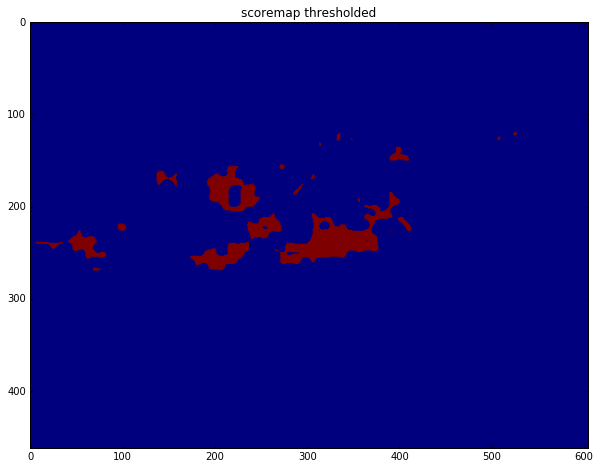

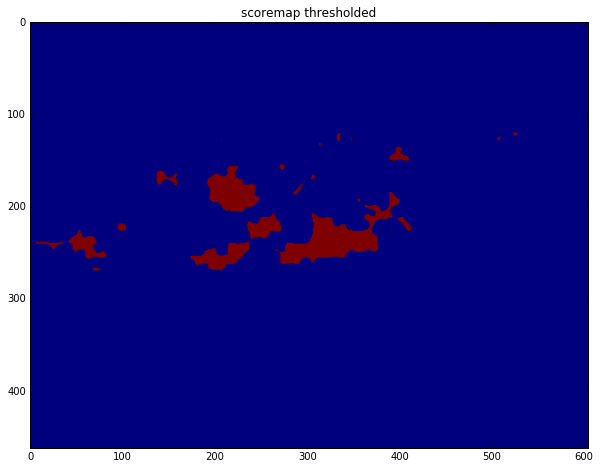

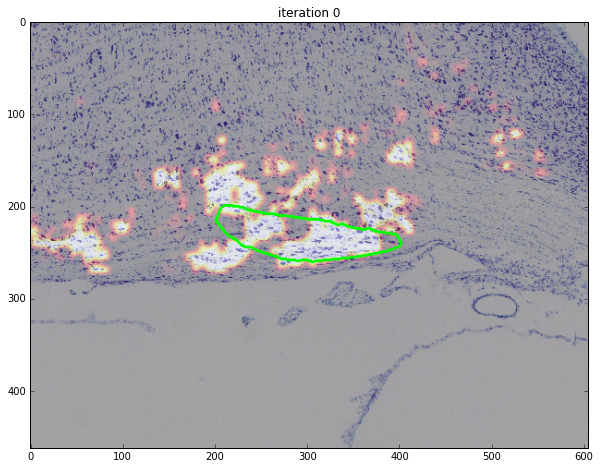

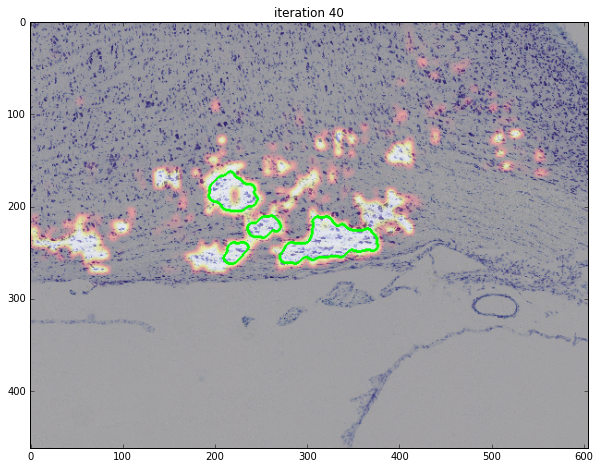

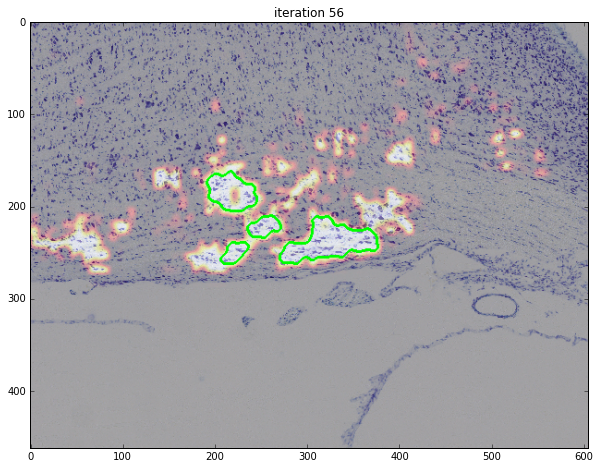

mean inside score: 0.997388
area: 5457
snake iteration: 56


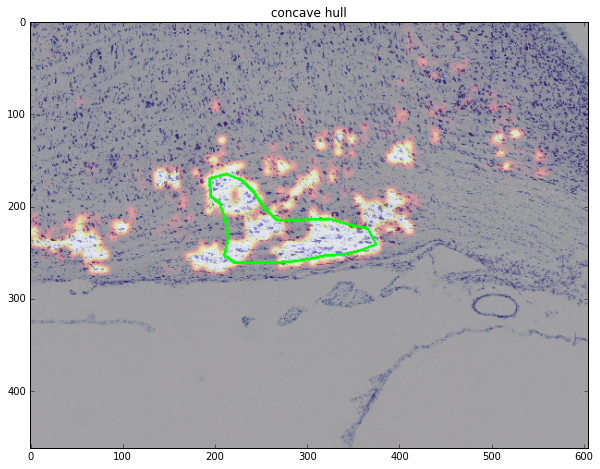

In [803]:
# for sec in range(first_detect_sec, last_detect_sec+1):
# for sec in range(first_detect_sec, first_detect_sec+10):
# for sec in range(174, last_detect_sec+1):
for sec in SECTIONS:
# for sec in [157]:
    
    autoAnnotations_dir = autoAnnotations_rootdir + '/' + stack + '/' + '%04d'%sec
    if not os.path.exists(autoAnnotations_dir):
        os.makedirs(autoAnnotations_dir)
    
    dm = DataManager(stack=stack, section=sec)
    dm._load_image(versions=['rgb-jpg'])
    cropped_img = dm.image_rgb_jpg[::8, ::8]
    
    scoremaps_dir = os.path.join(scoremaps_rootdir, stack, '%04d'%sec)
    
    print '\n'
    print sec
    
    #########################
        
    z_lowerlim = int(z_xy_ratio_downsampled*sec) - volume_zmin
    z_nextsec = int(z_xy_ratio_downsampled*(sec+1)) - volume_zmin
    z_previous = int(z_xy_ratio_downsampled*(sec-1)) - volume_zmin
    
    projected_annotation_labelmap = test_volume_atlas_projected[..., z_lowerlim]
    
    init_cnts = find_contour_points(projected_annotation_labelmap) # downsampled 16
    init_cnts = dict([(labels[label_ind], (cnts[0]+(volume_xmin, volume_ymin))*2) 
                      for label_ind, cnts in init_cnts.iteritems()])

    
# This has problems because some lms can not be detected even if there are some of their pixels on the map
#     label_indices_exist = set(np.unique(projected_annotation_labelmap))
    
#     label_indices_exist = set(np.r_[np.unique(test_volume_atlas_projected[..., z_nextsec]),
#                                 np.unique(test_volume_atlas_projected[..., z_previous]), 
#                                 np.unique(projected_annotation_labelmap)])
    
#     labels_exist = set([labels[i] for i in label_indices_exist])
    
    labels_exist = set(init_cnts.keys())
    
    valid_labels = labels_to_detect & labels_exist
    print valid_labels
    
    if len(valid_labels) == 0:
        sys.stderr.write('No valid labels exist.\n')
        continue

    new_res = []
    
    for l in valid_labels if SEE is None else SEE:
#     for l in ['7N']:
        
        print l
        
        try:
            scoremap_whole = bp.unpack_ndarray_file(os.path.join(scoremaps_dir, 
                                                       '%(stack)s_%(sec)04d_roi1_denseScoreMapLossless_%(label)s.bp' % \
                                                       {'stack': stack, 'sec': sec, 'label': l}))
        except:
            sys.stderr.write('No scoremap of %s exists\n' % (l))
            continue
                        
        
        dataset = stack + '_' + '%04d'%sec + '_roi1'
        
        interpolation_xmin, interpolation_xmax, \
        interpolation_ymin, interpolation_ymax = np.loadtxt(os.path.join(scoremaps_dir, 
                                                                         '%(dataset)s_denseScoreMapLossless_%(label)s_interpBox.txt' % \
                                        {'dataset': dataset, 'label': l})).astype(np.int)
        
        dense_scoremap_lossless = np.zeros((dm.image_height, dm.image_width), np.float32)
        dense_scoremap_lossless[interpolation_ymin:interpolation_ymax+1,
                                interpolation_xmin:interpolation_xmax+1] = scoremap_whole
        
        scoremap = dense_scoremap_lossless[::8, ::8]
        scoremap_height, scoremap_width = scoremap.shape[:2]

        init_cnt = init_cnts[l]
        init_cnt = contour_to_concave_hull(init_cnt, alpha=.01)
        
#         init_cnt = approximate_polygon(init_cnt, 5).astype(np.int)
#         init_cnt = subdivide_polygon(init_cnt, 5).astype(np.int)
        
        init_cnt_xmin, init_cnt_ymin = init_cnt.min(axis=0)
        init_cnt_xmax, init_cnt_ymax = init_cnt.max(axis=0)
        init_cnt_height, init_cnt_width = (init_cnt_ymax - init_cnt_ymin + 1, init_cnt_xmax - init_cnt_xmin + 1)
        init_cnt_cx, init_cnt_cy = np.mean(init_cnt, axis=0)
        
#         in_grid = grid_points_in_poly((init_cnt_height, init_cnt_width), init_cnt - (init_cnt_xmin, init_cnt_ymin))
        
        init_cnt_poly = Path(init_cnt)
        init_cnt_bbox_xs, init_cnt_bbox_ys = np.meshgrid(range(init_cnt_xmin, init_cnt_xmax+1), 
                                                         range(init_cnt_ymin, init_cnt_ymax+1))
        grid_points = np.c_[init_cnt_bbox_xs.flat, init_cnt_bbox_ys.flat]
        is_inside = init_cnt_poly.contains_points(grid_points)
        inside_points = grid_points[is_inside]
        
        score_max = 0
        for xshift in range(-200, 200, 10):
            for yshift in range(-200, 200, 10):
                shifted_ys = inside_points[:,1] + int(yshift)
                shifted_xs = inside_points[:,0] + int(xshift)
                valid = (shifted_ys >= 0) & (shifted_ys < scoremap_height-1) & (shifted_xs >= 0) & (shifted_xs < scoremap_width-1)
                shifted_ys = shifted_ys[valid]
                shifted_xs = shifted_xs[valid]
                score = scoremap[shifted_ys, shifted_xs].mean()
                if score_max < score:
                    score_max = score
                    shift_best = np.array([int(xshift), int(yshift)])
        
        print 'initial shift', shift_best, score_max
                
        if l == 'RtTg':
            shift_best = (0, 0)
        
        init_cnt = init_cnt + shift_best
        init_cnt_xmin += shift_best[0] 
        init_cnt_ymin += shift_best[1]
        init_cnt_xmax += shift_best[0] 
        init_cnt_ymax += shift_best[1]
        init_cnt_cx += shift_best[0]
        init_cnt_cy += shift_best[1]
        inside_points += shift_best
                
        init_cnt_height, init_cnt_width
        
        roi_margin = max(200, (400-min(init_cnt_height, init_cnt_width))/2)
        # should be set to the largest landmark diameter (so that it is ok even if contour is placed at the end of it)
        
        roi_xmin, roi_ymin = (max(0, init_cnt_xmin - roi_margin), max(0, init_cnt_ymin - roi_margin))
        roi_xmax, roi_ymax = (min(scoremap_width-1, init_cnt_xmax + roi_margin), min(scoremap_height-1, init_cnt_ymax + roi_margin))
        roi_height, roi_width = (roi_ymax + 1 - roi_ymin, roi_xmax + 1 - roi_xmin)
        
        inside_points_inroi = inside_points - (roi_xmin, roi_ymin)
        
        scoremap_roi = scoremap[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1] 
                
            
        ######## landmark specific settings ########
        
        if l == '12N':
            score_thresh = 0.3
        elif l == 'sp5':
            score_thresh = 0.3
        elif l == 'LRt':
            score_thresh = 0.95
        elif l == '7N':
            score_thresh = 0.95
        else:
            score_thresh = 0.8
            
        if l == 'sp5':
            smoothing = 1
        else:
            smoothing = 3
        
        if l == 'sp5':
            alpha = .1
        else:
            alpha = .04
            
        #############################################
    
        scoremap_thresholded = scoremap_roi > score_thresh
        
        if SHOW:
            plt.figure(figsize=(10,10));
            plt.imshow(scoremap_thresholded);
            plt.title('scoremap thresholded');
            plt.show();
        
        scoremap_thresholded_padded = np.zeros((roi_height + 100, roi_width + 100), np.bool)
        scoremap_thresholded_padded[50:-50, 50:-50] = scoremap_thresholded[:]
#         scoremap_thresholded_padded = binary_closing(scoremap_thresholded_padded, disk(10))
        scoremap_thresholded_padded = remove_small_holes(scoremap_thresholded_padded, 1000)
        scoremap_thresholded = scoremap_thresholded_padded[50:-50, 50:-50][:]

        if SHOW:        
            plt.figure(figsize=(10,10));
            plt.imshow(scoremap_thresholded);
            plt.title('scoremap thresholded');
            plt.show();
            
        init_levelset = np.zeros((roi_height, roi_width))
        init_levelset[inside_points_inroi[:,1], inside_points_inroi[:,0]] = 1.
        
        msnake = morphsnakes.MorphACWE(scoremap_thresholded.astype(np.float), smoothing=smoothing, lambda1=1., lambda2=1.)
        
        msnake.levelset = init_levelset.copy()
        # levelset values are either 1.0 or 0.0

#         scoremap_layer_viz = img_as_ubyte(plt.cm.hot(scoremap_thresholded.astype(np.float))[..., :3])

        scoremap_roi2 = scoremap_roi.copy()
        scoremap_roi2[scoremap_roi > 1.] = 1.
        scoremap_layer_viz = img_as_ubyte(plt.cm.hot(scoremap_roi2)[..., :3])
        scoremap_viz = img_as_ubyte(alpha_blending(scoremap_layer_viz,
                                                   cropped_img[roi_ymin:roi_ymax+1, roi_xmin:roi_xmax+1],
                                                   .3, 1))[..., :3]

#         plt.figure(figsize=(10,10));
#         plt.imshow(scoremap_roi);
#         plt.title('scoremap');
#         plt.show();
        
#         plt.figure(figsize=(10,10));
#         plt.imshow(scoremap_viz);
#         plt.title('scoremap thresholded');
#         plt.show();
        
        dq = deque([None, None])
        for i in range(1000): 
            
            # at stable stage, the levelset (thus contour) will oscilate, 
            # so instead of comparing to previous levelset, must compare to the one before the previous
            oneBefore_levelset = dq.popleft()
            
            if i > 10:
#                 print np.count_nonzero(msnake.levelset - oneBefore_levelset)
                if np.count_nonzero(msnake.levelset - oneBefore_levelset) < 3:
                    break

            dq.append(msnake.levelset)
        
            msnake.step()
            
            if SHOW:
                if i % 40 == 0:
                    show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

        if SHOW:
            show_levelset(msnake.levelset, scoremap_viz, 'iteration %d' % i)

        # in the final levelset, inside could be 0. or 1., hard to say        
        edge_arr = np.r_[msnake.levelset[:,0], msnake.levelset[:,-1], msnake.levelset[0], msnake.levelset[-1]]        
        pos_edge_num = np.count_nonzero(edge_arr)
        bool_arr = msnake.levelset.astype(np.bool)
        
        if pos_edge_num < len(edge_arr) - pos_edge_num:
            mean_inside_score = scoremap_roi[bool_arr].mean()
        else:
            mean_inside_score = scoremap_roi[~bool_arr].mean()
        print 'mean inside score:', mean_inside_score
        print 'area:', np.count_nonzero(bool_arr)
        print 'snake iteration:', i
        
        if mean_inside_score < .3:
            continue
        
#         m = binary_closing(msnake.levelset, disk(20))
#         plt.figure(figsize=(10,10));
#         plt.imshow(m);
#         plt.show();
        
        new_cnts = find_contours(msnake.levelset, 0.5)
        new_cnts = [c[:, ::-1] for c in new_cnts]
#         cnt_is_dense = True
        
#         if len(new_cnts) == 1:
#             new_cnt = new_cnts[0]
        if len(new_cnts) == 0:
            sys.stderr.write('No contour detected from snake levelset.\n')
            continue
#         elif len(new_cnts) > 1:
            
#             areas = np.array([Polygon(c).area for c in new_cnts])
            
#             sys.stderr.write('More than one contour are detected from snake levelset: ' + \
#                              ('%d '*len(new_cnts)+'\n') % tuple(areas))
            
#             new_cnts = [c for c, a in izip(new_cnts, areas) if a > area_lowerlim]
            
#             if len(new_cnts) == 1:
#                 new_cnt = new_cnts[0]
                
#             elif len(new_cnts) > 1:

    #                 new_cnt = sorted([(len(c),c[:,::-1].astype(np.int)) for c in new_cnts])[-1][1]
    #                 new_cnt = np.vstack([c[:, ::-1] for c in new_cnts])

    #             m = msnake.levelset.astype(np.int).copy()
    #             for dilate_iter in range(100):
    #                 m = binary_dilation(m, disk(5))

    #                 plt.figure(figsize=(10,10));
    #                 plt.imshow(m);
    #                 plt.show();

    # #                 import time
    # #                 t = time.time()

    #                 regions = regionprops(label(m))
    # #                 print [r.area for r in regions]
    #                 component_num = len(regions)

    # #                 _, component_num = skimage.morphology.label(m.astype(np.int), return_num=True)

    # #                 print time.time() - t    

    # #                 print component_num

    #                 if component_num == 1:
    #                     break

    #             for _ in range(dilate_iter):
    #                 plt.figure(figsize=(10,10));
    #                 plt.imshow(m);
    #                 plt.show();

    #                 m = binary_erosion(m, disk(5))

    #             new_cnts = sorted(find_contours(m, 0.5), key=len, reverse=True)
    #             new_cnt = new_cnts[0][:, ::-1]

#         all_cnt_points = np.concatenate([c[::5] for c in new_cnts])
        all_cnt_points = np.concatenate(new_cnts)
        
        new_cnt_subsampled = contour_to_concave_hull(all_cnt_points.astype(np.int), alpha=alpha)
        if new_cnt_subsampled is None:
            continue
    
        area_lowerlim = 1000
        area = Polygon(new_cnt_subsampled).area
        if area < area_lowerlim:
            sys.stderr.write('Concave hull area %d is too small.\n' % area)
            continue
    
#         # in grid_points_in_poly(), vertices are (r,c) instead of (x,y)
#         inside_ys, inside_xs =np.where(grid_points_in_poly((roi_height, roi_width), all_cnt_points[:, ::-1])) 
#         random_indices = np.random.choice(range(inside_ys.size), 1000, replace=False)
#         inside_points = np.c_[inside_xs[random_indices], inside_ys[random_indices]]
#         concave_hull, _ = alpha_shape(inside_points, alpha=.1)        

#         if not hasattr(concave_hull, 'exterior'):
#             continue

# #         concave_xs, concave_ys = concave_hull.exterior.coords.xy
# #         new_cnt = np.c_[concave_xs, concave_ys]
# #                 new_cnt = np.array(concave(all_cnt_points)[0])
# #                 new_cnt = np.array(sort_vertices_counterclockwise(new_cnt))
        
#         point_interval = 20
#         new_cnt_subsampled = np.array([concave_hull.exterior.interpolate(r, normalized=True).coords[:][0] 
#                              for r in np.arange(0, 1, point_interval/concave_hull.exterior.length)], 
#                    dtype=np.int)

        if SHOW:
            show_contours([new_cnt_subsampled], scoremap_viz, 'concave hull')

        new_cnt_subsampled = new_cnt_subsampled + (roi_xmin, roi_ymin)
        
#         new_cnt_subsampled = new_cnt[::20].copy()
#         new_cnt_subsampled = new_cnt.copy()
                
#         n_sample_points = Polygon(new_cnt).exterior.length / 20
#         new_cnt = new_cnt[np.linspace(0, new_cnt.shape[0]-1, n_sample_points).astype(np.int)]
                
#         new_lm = lm.copy()
        new_lm = {}
        new_lm['label'] = l
        new_lm['labelPos'] = new_cnt_subsampled.mean(axis=0)
        new_lm['vertices'] = new_cnt_subsampled.astype(np.int) * 8
        new_lm['refVertices'] = np.array(init_cnt).copy()
                            
        new_res.append(new_lm)
        
    ######################################
    
    timestamp = datetime.datetime.now().strftime("%m%d%Y%H%M%S")

    autoAnnotation_filepath = autoAnnotations_dir + '/%(stack)s_%(sec)04d_autoAnnotate_%(timestamp)s_consolidated.pkl' % \
                        {'stack': stack, 'sec': sec, 'timestamp': timestamp}

    pickle.dump(new_res, open(autoAnnotation_filepath, 'w'))   
        
    ######################################
    

    viz = cropped_img.copy()
    
    
    for l in valid_labels:
        ref_cnt = init_cnts[l].astype(np.int)
        for xy in ref_cnt:
            cv2.circle(viz, tuple(xy), 3, (0,255,0), -1)
            
    for lm in new_res:

    # for pt in init_cnt:
    #     cv2.circle(viz, tuple(pt), 2, (0,255,0,255), -1)

#         ref_cnt = lm['refVertices'].astype(np.int)
#         for xy in ref_cnt:
#             cv2.circle(viz, tuple(xy), 3, (0,255,0), -1)

        new_cnt = np.array(lm['vertices'])/8
                
        for xy in new_cnt:
            cv2.circle(viz, tuple(xy), 5, (255,0,0), -1)
        cv2.polylines(viz, [new_cnt.astype(np.int)], True, (255,0,0), 2)

#         if sec in section_contains_label and lm['label'] in section_contains_label[sec]:
#             dm = DataManager(stack=stack, section=sec)
#             user, ts, _, res = dm.load_proposal_review_result('yuncong', 'latest', 'consolidated')
#             manual_cnt = [x['vertices'] for x in res if x['label'] == lm['label']][0]
#             manual_cnt = np.array(manual_cnt)/8

#             for xy in manual_cnt.astype(np.int):
#                 cv2.circle(viz, tuple(xy), 3, (0,0,255), -1)
#             cv2.polylines(viz, [manual_cnt.astype(np.int)], True, (0,0,255), 2)


        lx, ly = np.array(lm['labelPos'])
        cv2.putText(viz, lm['label'], (int(lx)-10, int(ly)+10), cv2.FONT_HERSHEY_DUPLEX, 1, ((0,0,0)), 3)

    cv2.imwrite(autoAnnotationViz_dir + '/%(stack)s_%(sec)04d_autoAnnotationViz.jpg' % \
                {'stack': stack, 'sec': sec}, viz[..., ::-1])

In [783]:
SECTIONS = [157]

In [782]:
SHOW = True
SEE = ['LRt']

In [779]:
SHOW = False
SEE = None

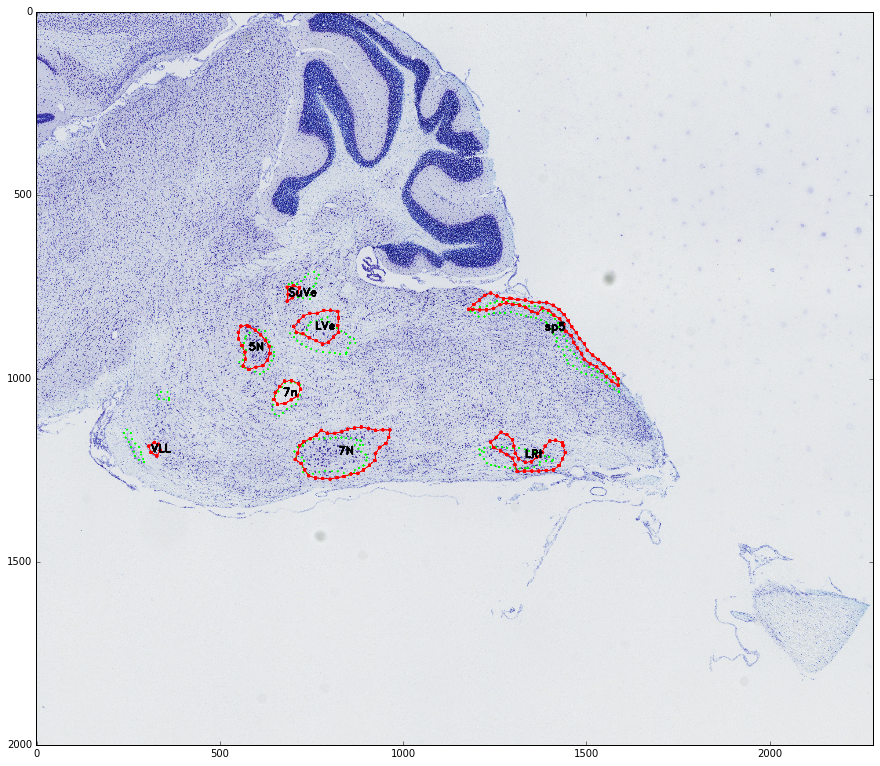

In [707]:
plt.figure(figsize=(15, 15));
plt.imshow(viz);

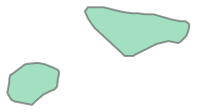

In [799]:
cnt = all_cnt_points.astype(np.int)

xmin, ymin = cnt.min(axis=0)
xmax, ymax = cnt.max(axis=0)
h, w = (ymax-ymin+1, xmax-xmin+1)
inside_ys, inside_xs =np.where(grid_points_in_poly((h, w), cnt[:, ::-1]-(ymin,xmin))) 
n = inside_ys.size
random_indices = np.random.choice(range(n), min(1000, n), replace=False)
inside_points = np.c_[inside_xs[random_indices], inside_ys[random_indices]]
concave_hull = alpha_shape(inside_points, alpha=alpha)
concave_hull

(150.0, 450.0, 160.0, 280.0)

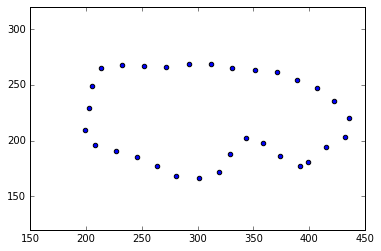

In [675]:
new_cnt_subsampled = contour_to_concave_hull(all_cnt_points.astype(np.int), alpha=.04)
plt.scatter(new_cnt_subsampled[:,0], new_cnt_subsampled[:,1])
plt.axis('equal')

In [ ]:
display(viz)